In [1]:
import tensorflow as tf 
import tensorflow_addons as tfa
from skimage.transform import warp, AffineTransform
import matplotlib.pyplot as plt
import numpy as np
import os
import glob
import pandas as pd
import math
import seaborn as sns
tf.random.set_seed(42)
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt


In [2]:

@tf.function
def apply_random_scaling(image, minval=-.02, maxval=.02):
    param = tf.random.uniform([], minval=minval, maxval=maxval)
    source_size = image.shape
    target_size = tf.cast(source_size[0]*(1.0+param), tf.int32), tf.cast(source_size[1]*(1.0+param), tf.int32)
    output = tf.image.resize_with_crop_or_pad(tf.image.resize(image, target_size), source_size[0], source_size[1])
    return output, param

def apply_random_shearing(image, minval=-5., maxval=5.):
    #param = tf.random.uniform([], minval=tf.math.atan(minval/image.shape[1]), maxval=tf.math.atan(maxval/image.shape[1]))
    #param = tf.random.uniform([], minval=tf.math.atan(), maxval=tf.math.atan(maxval/image.shape[1]))
    param = np.random.uniform(low=minval, high=maxval)
    output = warp(np.array(image), AffineTransform(shear=np.arctan(param/image.shape[1])).inverse)
    return output, param
@tf.function
def apply_random_rotation(image, minval=-7, maxval=7):
    param = tf.random.uniform([], minval=minval, maxval=maxval)
    output = tfa.image.rotate(image, param*math.pi/180.0, interpolation='BILINEAR')
    return output, param


def apply_test_time_augmentation(image, labels, image_id):
    '''Implements TTA, https://arxiv.org/pdf/1911.06475.pdf pag13:
    
    (...) for each test CXR, we applied a random 
    transformation (amongst horizontal flipping, 
    rotating ±7 degrees, scaling±2%,and shearing±5 pixels) 10 times (...)
    
    :param image - the input image
    :param labels - the labels associated with the image
    :param image_id - an ordinal or id associated with the image
    
    :returns - a DataFrame containing one row for each generated image (+1 for the original one), a list of generated images and labels. 
    The dataframe contains the augmentation method used, the parameter and the image/label filenames.
    '''
    dataframe = pd.DataFrame()
    image_list = list()
    image_list.append((image, labels))
    
    dataframe = dataframe.append({'image_id':image_id,
                                      'tta_id':0,
                                      'image_fn':'{}_{}_image.npy'.format(image_id, 0),
                                      'labels_fn':'{}_label.npy'.format(image_id),
                                      'method':'ORIGINAL',
                                      'param':0.0}, ignore_index=True)
    
    for i in range(1, 11):

        random_function = tf.random.uniform([], minval=0, maxval=4, dtype=tf.int32)

        output = image
        param = tf.constant(0.0)        
        
        if tf.equal(random_function, 0):
            output = tf.image.flip_left_right(image)
            param = tf.constant(0.0)
            method = 'FLIP'
        if tf.equal(random_function, 1):
            output, param = apply_random_rotation(image)
            method = 'ROTATION'
        if tf.equal(random_function, 2):
            output, param = apply_random_scaling(image)
            method = 'SCALING'
        if tf.equal(random_function, 3):
            output, param = apply_random_shearing(image)
            method = 'SHEAR'
        image_list.append((output, labels))
        
        dataframe = dataframe.append({'image_id':image_id,
                                      'tta_id':int(i),
                                      'image_fn':'{}_{}_image.npy'.format(image_id, i),
                                      'labels_fn':'{}_label.npy'.format(image_id),
                                      'method':method,
                                      'param':float(param)}, ignore_index=True)
    return dataframe, image_list


def record_parser(example, image_size=224):
    example_fmt = {
        'label': tf.io.FixedLenFeature([14], tf.float32),
        'image': tf.io.FixedLenFeature([],tf.string, default_value='')}
    parsed = tf.io.parse_single_example(example, example_fmt)
    image = tf.io.decode_png(parsed["image"],channels=3)
    image.set_shape([image_size, image_size, 3])
    image = tf.image.convert_image_dtype(image, tf.float32)
    return image, parsed['label']

def normalize_image(img,labels):
    imagenet_mean = np.array([0.485, 0.456, 0.406])
    imagenet_std = np.array([0.229, 0.224, 0.225])
    img = (img - imagenet_mean) / imagenet_std
    return img,labels

def make_dataset(filename, image_size=224):
  base_path = 'datasets/'
  full_path = os.path.join(base_path,filename)
  dataset = tf.data.TFRecordDataset(full_path)
  parser = lambda x, size=image_size: record_parser(x, image_size=size)
  parsed_dataset = dataset.map(parser,num_parallel_calls = tf.data.experimental.AUTOTUNE)
  parsed_dataset = parsed_dataset.map(normalize_image,num_parallel_calls = tf.data.experimental.AUTOTUNE)
  return parsed_dataset

def make_tta_dataset(csv_path, test_dataset_path='test_set_cropped.tfrecords', image_size=224):
    '''
    TTA Dataset is built upon the test set. If the csv file exists in the given path, then this function use it to load the dataset.
    Otherwise first the test dataset is loaded and each image is saved in a different numpy file. 
    '''
    tta_images = list()
    tta_labels = list()
    folder = os.path.dirname(csv_path)
    
    if not os.path.isfile(csv_path):
        print("Dataset not found. Generating...")
        # Generate dataset
        # Load test dataset
        
        os.makedirs(folder, exist_ok=True)
        test_dataset = make_dataset(test_dataset_path).prefetch(1)
        # Apply augmentation
        tta_dataset = list()
        tta_csv = pd.DataFrame()
        for r, record in enumerate(test_dataset):
            aug_dataframe, aug_images = apply_test_time_augmentation(record[0], record[1], r)
            tta_csv = tta_csv.append(aug_dataframe, ignore_index=True)
            for (_, (image_fn, labels_fn)), (aug_image, aug_label) in zip(aug_dataframe[['image_fn', 'labels_fn']].iterrows(), aug_images):
                np.save(os.path.join(folder, image_fn), aug_image)
                if _ == 0:
                    np.save(os.path.join(folder, labels_fn), aug_label)
        tta_csv.to_csv(csv_path)
    
    print("Loading dataset "+ csv_path)
    # Load dataset
    csv = pd.read_csv(csv_path, index_col=0)
    for g, augmentation_group in csv.loc[csv['method'] != 'ORIGINAL'].groupby(['image_id']):
        current_aug = list()
        for _, (image_fn, labels_fn) in augmentation_group[['image_fn', 'labels_fn']].iterrows():
            current_aug.append(np.load(os.path.join(folder, image_fn)))
            label = np.load(os.path.join(folder, labels_fn))
        tta_images.append(np.stack(current_aug))
        tta_labels.append(label)
    return tf.data.Dataset.from_tensor_slices((tta_images, tta_labels))

batch_size = 64
#train_dataset = make_dataset('training_cropped.tfrecords').shuffle(buffer_size=128).batch(batch_size, drop_remainder=True).prefetch(1)

#train_dataset = make_dataset('training_cropped.tfrecords').batch(batch_size, drop_remainder=True).prefetch(1)

# UNCOMMENT TO ENABLE TRAINING
# cond_train_dataset = make_dataset('conditional_training.tfrecords').shuffle(buffer_size=128).batch(batch_size).prefetch(1) # Dataset of only positive parents, used for pre-training
# train_dataset = make_dataset('training_cropped.tfrecords').shuffle(buffer_size=128).batch(batch_size).prefetch(1) # Full dataset, using for fine-tuning the network
val_dataset = make_dataset('validation_cropped.tfrecords').shuffle(buffer_size=128).batch(batch_size, drop_remainder=True).prefetch(1)
test_dataset = make_dataset('test_set_cropped.tfrecords').batch(batch_size, drop_remainder=False).prefetch(1)
tta_dataset = make_tta_dataset('datasets/tta_dataset/tta.csv')

Loading dataset datasets/tta_dataset/tta.csv


In [25]:
def plot_aurocs(model_predictions, ground_truths):
    label_names = ['No Finding', 'Enlarged Cardiomediastinum', 'Cardiomegaly', 'Lung Opacity', 'Lung Lesion', 'Edema', 'Consolidation', 'Pneumonia', 'Atelectasis', 'Pneumothorax', 'Pleural Effusion', 'Pleural Other', 'Fracture', 'Support Devices']
    target_labels = ['Cardiomegaly','Edema','Consolidation','Atelectasis','Pleural Effusion']
    fig, ax = plt.subplots(1,1, figsize = (7, 7))
    j = 1
    aurocs = []
    results = pd.DataFrame()
    for (i, label) in enumerate(label_names):
      fpr, tpr, thresholds = roc_curve(ground_truths[:,i].astype(int), model_predictions[:,i])
      
      if (label in target_labels):
        #ax = fig.add_subplot(2,3,j)
        score = auc(fpr, tpr)
        ax.plot(fpr, tpr, label = '%s (AUC:%0.3f)'  % (label, score))
        aurocs.append(auc(fpr, tpr))
        results = results.append({'Label': label, 'Score':score},ignore_index = True)
      ax.legend()
      ax.set_xlabel('False Positive Rate')
      ax.set_ylabel('True Positive Rate')
      ax.set_title('AUROC: {:0.4f}'.format(np.mean(aurocs)))
    return results

def apply_bayes_to_predictions(predictions):
    predictions[:,5] = predictions[:,3] * predictions[:,5]
    predictions[:,6] = predictions[:,3] * predictions[:,6]
    predictions[:,7] = predictions[:,3] * predictions[:,7]
    predictions[:,4] = predictions[:,3] * predictions[:,4]
    predictions[:,8] = predictions[:,3] * predictions[:,8]
    predictions[:,2] = predictions[:,1] * predictions[:,2]
    return predictions

def get_model_predictions(model_path, dataset, apply_bayes, apply_tta):
    model = tf.keras.models.load_model(model_path)
    predictions = None
    ground_truth = None
    for i, (x, y) in enumerate(dataset):
        p = model.predict(x)
        if apply_tta:
            # ..then x is no more a batch but a set of 10 augmentations, y is their label
            p = np.mean(p, axis=0, keepdims=True)
            y = y[tf.newaxis, ...].numpy()
        if apply_bayes:
            p = apply_bayes_to_predictions(p)
        if predictions is None:
            predictions = p
        else:
            predictions = np.concatenate([predictions, p])
        
        if ground_truth is None:
            ground_truth = y
        else:
            ground_truth = np.concatenate([ground_truth, y])
    return predictions, ground_truth

In [7]:
model_name = 'DenseNet121'
basepath_pt = 'ModelsRetrained/{}/PreTrained/'.format(model_name)
basepath_ft = 'ModelsRetrained/{}/FineTuned/'.format(model_name)
pretrained_models = sorted([basepath_pt + p for p in os.listdir(basepath_pt)])
finetuned_models = sorted([basepath_ft + p for p in os.listdir(basepath_ft)])

In [8]:
pred_pt, gt_pt = get_model_predictions(pretrained_models[-1], test_dataset, apply_bayes=False, apply_tta=False)
pred_ft, gt_ft = get_model_predictions(model_path=finetuned_models[-1], dataset=test_dataset, apply_bayes=False, apply_tta=False)
pred_ft_bayes, gt_ft_bayes = get_model_predictions(model_path=finetuned_models[-1], dataset=test_dataset, apply_bayes=True, apply_tta=False)
pred_ft_tta_nobayes, gt_ft_tta_nobayes = get_model_predictions(model_path=finetuned_models[-1], dataset=tta_dataset, apply_bayes=False, apply_tta=True)
pred_ft_tta, gt_ft_tta = get_model_predictions(model_path=finetuned_models[-1], dataset=tta_dataset, apply_bayes=False, apply_tta=True)
pred_ft_tta_bayes, gt_ft_tta_bayes = get_model_predictions(model_path=finetuned_models[-1], dataset=tta_dataset, apply_bayes=True, apply_tta=True)

In [28]:
pred_ft_tta, gt_ft_tta = get_model_predictions(model_path=finetuned_models[-1], dataset=tta_dataset, apply_bayes=False, apply_tta=True)
pred_ft_tta_bayes, gt_ft_tta_bayes = get_model_predictions(model_path=finetuned_models[-1], dataset=tta_dataset, apply_bayes=True, apply_tta=True)

No handles with labels found to put in legend.
/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
No handles with labels found to put in legend.
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_ranking.py:813: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)
No handles with labels found to put in legend.
/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
No handles with labels found to put in legend.
/usr/local/lib/python3.6/dist-p

,Label,Score
0,Cardiomegaly,0.707665
1,Edema,0.942411
2,Consolidation,0.853125
3,Atelectasis,0.847874
4,Pleural Effusion,0.933311


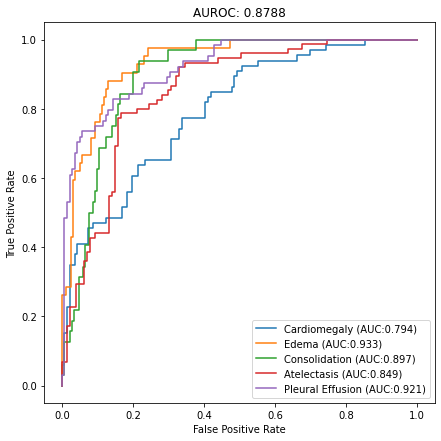

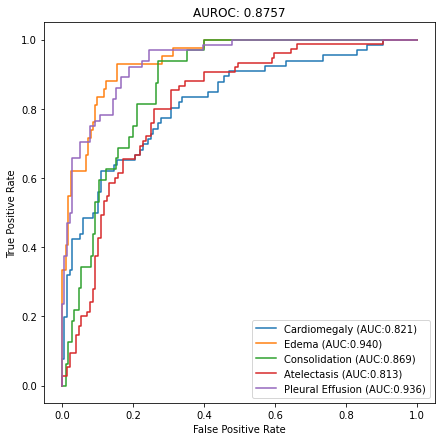

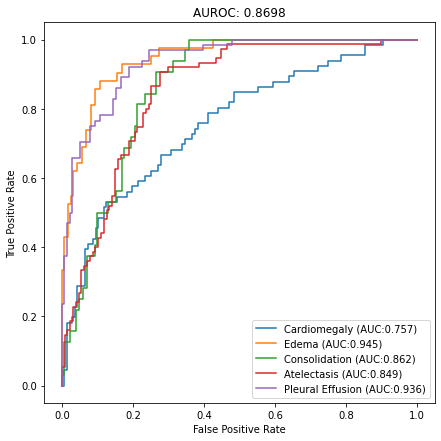

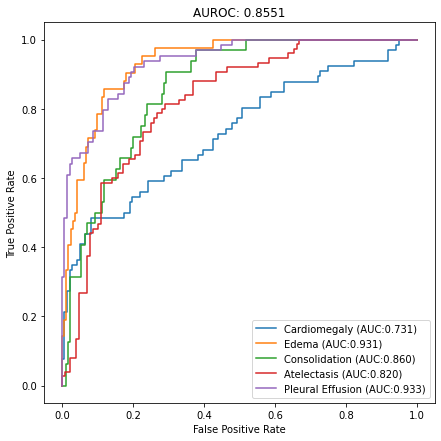

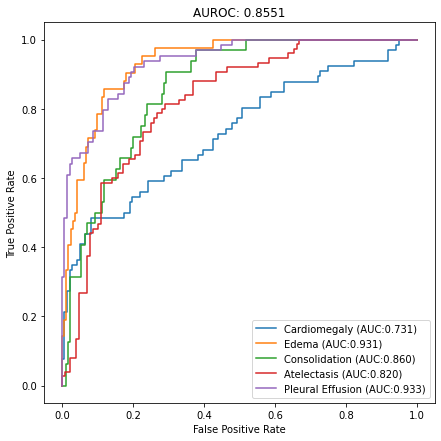

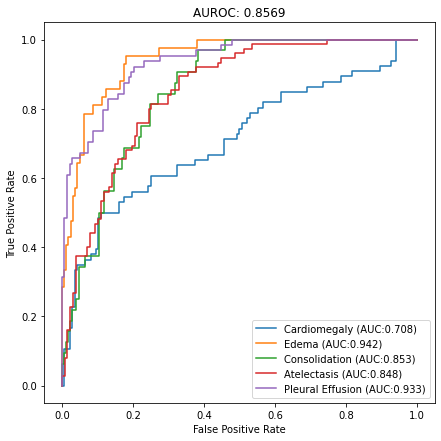

In [29]:
plot_aurocs(pred_pt, gt_pt)
plot_aurocs(pred_ft, gt_ft)
plot_aurocs(pred_ft_bayes, gt_ft_bayes)
plot_aurocs(pred_ft_tta_nobayes, gt_ft_tta_nobayes)
plot_aurocs(pred_ft_tta, gt_ft_tta)
plot_aurocs(pred_ft_tta_bayes, gt_ft_tta_bayes)

1) Validation scores are much lower than test scores
2) Conditional Training actually make score worse in many cases (does it make sense to use it at all?)
3) TODO: Check the scores from the original paper wrt ours, Check how it is implemented.

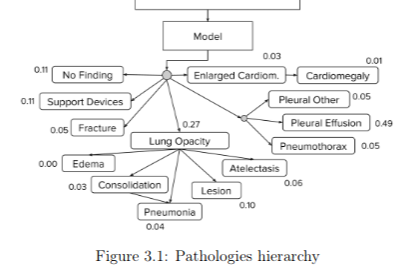

In [ ]:
plt.figure(figsize=(32, )*2)
sns.heatmap(val_log.loc[:, val_log.columns.difference(['model', 'path'])], annot=True, fmt='.3f')

In [7]:



label_names = ['No Finding', 'Enlarged Cardiomediastinum', 'Cardiomegaly', 'Lung Opacity', 'Lung Lesion', 'Edema', 'Consolidation', 'Pneumonia', 'Atelectasis', 'Pneumothorax', 'Pleural Effusion', 'Pleural Other', 'Fracture', 'Support Devices']

model_name = 'DenseNet121'
basepath = 'ModelsRetrained/{}/FineTuned/'.format(model_name)
modelspath = sorted([basepath + p for p in os.listdir(basepath)])
val_log_ft = pd.DataFrame()

modelspath = [modelspath[-1]]
for mp in modelspath:
    print("Evaluating" + mp)
    model = tf.keras.models.load_model(mp)
    predictions = None
    ground_truth = None
    for i, (x, y) in enumerate(val_dataset):
        p = model.predict(x)
        
        if predictions is None:
            predictions = p
        else:
            predictions = np.concatenate([predictions, p])
        
        if ground_truth is None:
            ground_truth = y
        else:
            ground_truth = np.concatenate([ground_truth, y])
    
    aucs = [tf.keras.metrics.AUC()(ground_truth[:, lab], predictions[:, lab]).numpy() for lab in range(y.shape[-1])]
    new_row = {name: auc for name, auc in zip(label_names, aucs)}
    new_row['model'] = model_name
    new_row['path'] = mp
    val_log_ft = val_log_ft.append(new_row, ignore_index=True)

EvaluatingModelsRetrained/DenseNet121/FineTuned/model-50.hdf5


In [ ]:
val_log_ft['mean']=val_log_ft.mean(axis=1)
plt.figure(figsize=(32, )*2)
sns.heatmap(val_log_ft.loc[:, val_log.columns.difference(['model', 'path'])], annot=True, fmt='.3f')

In [ ]:
val_log_ft

In [12]:
val_log_ft

,Atelectasis,Cardiomegaly,Consolidation,Edema,Enlarged Cardiomediastinum,Fracture,Lung Lesion,Lung Opacity,No Finding,Pleural Effusion,Pleural Other,Pneumonia,Pneumothorax,Support Devices,model,path,mean
0,0.724781,0.804022,0.687019,0.836703,0.668205,0.825409,0.759907,0.720536,0.886056,0.878163,0.789598,0.736037,0.857801,0.884955,DenseNet121,ModelsRetrained/DenseNet121/FineTuned/model-50...,0.789942


In [ ]:
import seaborn as sns
sns.relplot(x='path', y='score', row='label', kind='line', data=val_log.melt(id_vars=['path', 'model'], var_name='label', value_name='score'))

In [ ]:
temp.append(np.array(aucs), ignore_index=True)

In [49]:
np.array(aucs)

array([0.954241  , 0.83035713, 0.8740741 , 0.8572825 , 0.8762712 ,
       0.79142857, 0.7632933 , 0.8145833 , 0.73409086, 0.9072681 ,
       0.8498498 , 0.96825397, 0.8907104 , 0.80400777], dtype=float32)

In [14]:
lab=0
tf.keras.metrics.AUC(multi_label=True)(tf.stack([1-ground_truth[:, lab], ground_truth[:, lab]], axis=-1),tf.stack([1-predictions[:, lab], predictions[:, lab]], axis=-1)).numpy()

0.883821

<tf.Tensor: shape=(1856, 2), dtype=float32, numpy=
array([[1., 0.],
       [1., 0.],
       [1., 0.],
       ...,
       [1., 0.],
       [1., 0.],
       [1., 0.]], dtype=float32)>

In [10]:
ground_truth.shape

(1856, 14)